## Imports and Setup

In [1]:
import os, gc, json, warnings
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import io
from scipy.stats import kurtosis, skew
from scipy.signal import welch

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from tqdm.auto import tqdm

from IPython.display import display as ipy_display, Image as IPyImage

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

## Configuration

In [2]:
def _find_kaggle_input() -> Path:
    base = Path('/kaggle/input')
    if not base.exists():
        return Path('/kaggle/input/ninapro-db7/Dataset')

    def _has_subjects(p: Path) -> bool:
        if not p.is_dir():
            return False
        return any(
            c.is_dir() and c.name.lower().startswith('subject_')
            for c in p.iterdir()
        )
    def _search(root: Path, depth: int = 0) -> Path | None:
        if depth > 5:
            return None
        if _has_subjects(root):
            return root
        try:
            for child in sorted(root.iterdir()):
                if child.is_dir():
                    result = _search(child, depth + 1)
                    if result is not None:
                        return result
        except PermissionError:
            pass
        return None

    result = _search(base)
    if result is not None:
        return result

    # Last resort
    return Path('/kaggle/input/ninapro-db7/Dataset')


class Config:
    """Global configuration (EMG-only)"""

    KAGGLE_INPUT   = _find_kaggle_input()
    KAGGLE_WORKING = Path('/kaggle/working')
    CHECKPOINT_DIR = KAGGLE_WORKING / 'checkpoints'
    PLOT_DIR       = KAGGLE_WORKING / 'eda_plots'

    SUBJECTS      = list(range(1, 23))
    EMG_CHANNELS  = 12
    SAMPLING_RATE = 2000  # Hz

    RANDOM_SEED = 42


import random
random.seed(Config.RANDOM_SEED)
np.random.seed(Config.RANDOM_SEED)

Config.CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)
Config.PLOT_DIR.mkdir(parents=True, exist_ok=True)

print(f'Configuration set')
print(f'  Checkpoint dir : {Config.CHECKPOINT_DIR}')
print(f'  Plot dir       : {Config.PLOT_DIR}')
print(f'  Sampling rate  : {Config.SAMPLING_RATE} Hz')

Configuration set
  Checkpoint dir : /kaggle/working/checkpoints
  Plot dir       : /kaggle/working/eda_plots
  Sampling rate  : 2000 Hz


## Select EMG and Labels only

In [3]:
class EMGPreprocessor:

    def apply(self, mat_path: Path):
        data = io.loadmat(str(mat_path))

        emg_key = next((k for k in data if k.lower() == 'emg'), None)
        lbl_key = next(
            (k for k in data
             if k.lower() in ('restimulus', 'stimulus', 'label', 'labels')),
            None
        )

        if emg_key is None:
            raise KeyError(
                f'No EMG column in {mat_path.name}. '
                f'Available keys: {[k for k in data if not k.startswith("_")]}'
            )
        if lbl_key is None:
            raise KeyError(
                f'No label column in {mat_path.name}. '
                f'Available keys: {[k for k in data if not k.startswith("_")]}'
            )

        emg    = data[emg_key].astype(np.float32)          # raw, no processing
        labels = data[lbl_key].flatten().astype(np.int32)

        n = min(len(emg), len(labels))
        return emg[:n], labels[:n]

## Checkpoint-Based Subject Loader

In [4]:
class CheckpointLoader:
    def __init__(self):
        self.checkpoint_dir = Config.CHECKPOINT_DIR

    def _ckpt_path(self, sid: int) -> Path:
        return self.checkpoint_dir / f'subject_{sid:02d}.npz'

    def _find_subject_dir(self, sid: int) -> Path:
        candidates = [
            Config.KAGGLE_INPUT / f'Subject_{sid}',   # real Kaggle layout
            Config.KAGGLE_INPUT / f'subject_{sid}',
            Config.KAGGLE_INPUT / f'DB7_s{sid}',
            Config.KAGGLE_INPUT / f'DB7_S{sid}',
            Config.KAGGLE_INPUT / f's{sid}',
            Config.KAGGLE_INPUT / f'S{sid}',
            Config.KAGGLE_INPUT / f'{sid}',
        ]
        for p in candidates:
            if p.is_dir():
                return p

        # Last-resort fuzzy scan
        for p in sorted(Config.KAGGLE_INPUT.iterdir()):
            if p.is_dir() and p.name.lower().endswith(str(sid)):
                return p

        raise FileNotFoundError(
            f'Cannot locate folder for subject {sid} under {Config.KAGGLE_INPUT}.\n'
            f'Contents: {[x.name for x in Config.KAGGLE_INPUT.iterdir()]}'
        )

    def _load_subject(self, sid: int, preprocessor: EMGPreprocessor):
        """Concatenate all exercise .mat files for one subject."""
        subj_dir  = self._find_subject_dir(sid)
        mat_files = sorted(subj_dir.glob('*.mat'))
        if not mat_files:
            mat_files = sorted(subj_dir.rglob('*.mat'))
        if not mat_files:
            raise FileNotFoundError(f'No .mat files in {subj_dir}')

        emg_parts, lbl_parts = [], []
        for mat_file in mat_files:
            emg, labels = preprocessor.apply(mat_file)
            emg_parts.append(emg)
            lbl_parts.append(labels)

        return np.vstack(emg_parts), np.concatenate(lbl_parts)
    def process_and_checkpoint_all(self, subjects, preprocessor: EMGPreprocessor):
        available = []

        for sid in tqdm(subjects, desc='Loading subjects'):
            ckpt = self._ckpt_path(sid)
            if ckpt.exists():
                available.append(sid)
                print(f'  Subject_{sid:02d}: checkpoint exists — skipped')
                continue
            try:
                emg, labels = self._load_subject(sid, preprocessor)
                np.savez_compressed(ckpt, emg=emg, labels=labels)
                available.append(sid)
                print(f'  Subject {sid:02d}: saved {len(emg):,} rows -> {ckpt.name}')
                del emg, labels
                gc.collect()
            except Exception as exc:
                print(f'  Subject {sid:02d}: FAILED -- {exc}')

        return available

    def iter_subjects(self, subjects):
        """Yield (sid, emg, labels) from checkpoints."""
        for sid in subjects:
            ckpt = self._ckpt_path(sid)
            if not ckpt.exists():
                continue
            data = np.load(ckpt)
            yield sid, data['emg'], data['labels']
            del data
            gc.collect()

    def build_sample_dataset(self, subjects, preprocessor=None,
                             max_per_subject=None, remove_rest=False):
        emg_parts, lbl_parts, sid_parts = [], [], []

        for sid, emg, labels in self.iter_subjects(subjects):
            if remove_rest:
                idx    = labels != 0
                emg    = emg[idx]
                labels = labels[idx]

            emg_parts.append(emg)
            lbl_parts.append(labels)
            sid_parts.append(np.full(len(emg), sid, dtype=np.int32))
            del emg, labels
            gc.collect()

        if not emg_parts:
            contents = (
                [x.name for x in Config.KAGGLE_INPUT.iterdir()]
                if Config.KAGGLE_INPUT.exists() else ['DIRECTORY NOT FOUND']
            )
            raise RuntimeError(
                'No subject data loaded.\n'
                f'  KAGGLE_INPUT : {Config.KAGGLE_INPUT}\n'
                f'  Contents     : {contents}'
            )

        return (
            np.vstack(emg_parts),
            np.concatenate(lbl_parts),
            np.concatenate(sid_parts),
        )


## Load & Checkpoint All Subjects

In [5]:
preprocessor = EMGPreprocessor()
loader       = CheckpointLoader()

print('\n=== Kaggle input resolution ===')
print(f'  Resolved KAGGLE_INPUT : {Config.KAGGLE_INPUT}')
print(f'  Exists                : {Config.KAGGLE_INPUT.exists()}')
print('\n=== /kaggle/input tree (slugs + subject folders) ===')
_base = Path('/kaggle/input')
if _base.exists():
    for _slug in sorted(_base.iterdir()):
        print(f'  {_slug.name}/')
        for _child in sorted(_slug.iterdir())[:6]:   # first 6 children
            _mats = list(_child.rglob('*.mat')) if _child.is_dir() else []
            _tag  = f'  ({len(_mats)} .mat)' if _mats else ''
            print(f'    {_child.name}/{_tag}')
else:
    print('  /kaggle/input does not exist')
print()
print('=== Resolved KAGGLE_INPUT contents ===')
if Config.KAGGLE_INPUT.exists():
    for item in sorted(Config.KAGGLE_INPUT.iterdir()):
        if item.is_dir():
            mats   = list(item.rglob('*.mat'))
            sample = [m.name for m in mats[:3]]
            print(f'  [DIR]  {item.name:<20}  ({len(mats)} .mat files)  e.g. {sample}')
        else:
            print(f'  [FILE] {item.name}')
else:
    print(f'  *** KAGGLE_INPUT does NOT exist: {Config.KAGGLE_INPUT} ***')
    print('  Please check the /kaggle/input tree above and update KAGGLE_INPUT manually.')
print('=' * 40)

# Hard stop if auto-discovery failed
if not Config.KAGGLE_INPUT.exists():
    raise RuntimeError(
        f"KAGGLE_INPUT not found: {Config.KAGGLE_INPUT}\n"
        "Fix: set KAGGLE_INPUT manually in Config, e.g.:\n"
        "  KAGGLE_INPUT = Path('/kaggle/input/<your-slug>/Dataset')\n"
        "Run the diagnostic block above to see available slugs."
    )
available_subjects = loader.process_and_checkpoint_all(
    subjects     = Config.SUBJECTS,
    preprocessor = preprocessor,
)

print(f'\nSubjects available for EDA: {available_subjects}')

total_samples    = 0
all_gesture_sets = set()

for sid, emg, labels in loader.iter_subjects(available_subjects):
    total_samples += len(emg)
    all_gesture_sets.update(labels.tolist())
    del emg, labels
    gc.collect()

print(f'\nDataset summary')
print(f'  Subjects        : {len(available_subjects)}')
print(f'  Total samples   : {total_samples:,}')
print(f'  Gesture classes : {len(all_gesture_sets)}')
print(f'  EMG channels    : {Config.EMG_CHANNELS}')
print(f'  Sampling rate   : {Config.SAMPLING_RATE} Hz')


=== Kaggle input resolution ===
  Resolved KAGGLE_INPUT : /kaggle/input/ninapro-db7/Dataset
  Exists                : True

=== /kaggle/input tree (slugs + subject folders) ===
  ninapro-db7/
    Dataset/  (44 .mat)

=== Resolved KAGGLE_INPUT contents ===
  [DIR]  Subject_1             (2 .mat files)  e.g. ['S1_E2_A1.mat', 'S1_E1_A1.mat']
  [DIR]  Subject_10            (2 .mat files)  e.g. ['S10_E1_A1.mat', 'S10_E2_A1.mat']
  [DIR]  Subject_11            (2 .mat files)  e.g. ['S11_E1_A1.mat', 'S11_E2_A1.mat']
  [DIR]  Subject_12            (2 .mat files)  e.g. ['S12_E1_A1.mat', 'S12_E2_A1.mat']
  [DIR]  Subject_13            (2 .mat files)  e.g. ['S13_E1_A1.mat', 'S13_E2_A1.mat']
  [DIR]  Subject_14            (2 .mat files)  e.g. ['S14_E1_A1.mat', 'S14_E2_A1.mat']
  [DIR]  Subject_15            (2 .mat files)  e.g. ['S15_E2_A1.mat', 'S15_E1_A1.mat']
  [DIR]  Subject_16            (2 .mat files)  e.g. ['S16_E2_A1.mat', 'S16_E1_A1.mat']
  [DIR]  Subject_17            (2 .mat files)  e.

Loading subjects:   0%|          | 0/22 [00:00<?, ?it/s]

  Subject 01: saved 4,327,442 rows -> subject_01.npz
  Subject 02: saved 4,325,971 rows -> subject_02.npz
  Subject 03: saved 4,334,873 rows -> subject_03.npz
  Subject 04: saved 4,329,311 rows -> subject_04.npz
  Subject 05: saved 4,330,066 rows -> subject_05.npz
  Subject 06: saved 4,325,143 rows -> subject_06.npz
  Subject 07: saved 4,329,648 rows -> subject_07.npz
  Subject 08: saved 4,328,488 rows -> subject_08.npz
  Subject 09: saved 4,330,089 rows -> subject_09.npz
  Subject 10: saved 4,327,800 rows -> subject_10.npz
  Subject 11: saved 4,327,092 rows -> subject_11.npz
  Subject 12: saved 4,322,051 rows -> subject_12.npz
  Subject 13: saved 4,331,025 rows -> subject_13.npz
  Subject 14: saved 4,330,839 rows -> subject_14.npz
  Subject 15: saved 4,330,069 rows -> subject_15.npz
  Subject 16: saved 4,328,948 rows -> subject_16.npz
  Subject 17: saved 4,330,992 rows -> subject_17.npz
  Subject 18: saved 4,331,061 rows -> subject_18.npz
  Subject 19: saved 4,326,839 rows -> subject_

## Build Full Dataset for EDA

In [6]:
emg_sample, labels_sample, sids_sample = loader.build_sample_dataset(
    subjects     = available_subjects,
    remove_rest  = False,
    # max_per_subject intentionally omitted -> uses every row
)
gc.collect()

print(f'  Sampled dataset shape : {emg_sample.shape}')
print(f'  Memory (MB)           : {emg_sample.nbytes / 1e6:.1f}')
print(f'  Gesture classes       : {len(np.unique(labels_sample))}')
print(f'  Class distribution    :')
uniq, cnts = np.unique(labels_sample, return_counts=True)
for g, c in zip(uniq, cnts):
    print(f'    G{g:2d}: {c:>8,}  ({c/len(labels_sample)*100:.1f}%)')

  Sampled dataset shape : (96355557, 12)
  Memory (MB)           : 4625.1
  Gesture classes       : 41
  Class distribution    :
    G 0: 40,925,328  (42.5%)
    G 1: 1,413,193  (1.5%)
    G 2: 1,411,109  (1.5%)
    G 3: 1,367,946  (1.4%)
    G 4: 1,394,249  (1.4%)
    G 5: 1,350,877  (1.4%)
    G 6: 1,384,014  (1.4%)
    G 7: 1,412,146  (1.5%)
    G 8: 1,403,833  (1.5%)
    G 9: 1,430,784  (1.5%)
    G10: 1,335,609  (1.4%)
    G11: 1,386,085  (1.4%)
    G12: 1,401,377  (1.5%)
    G13: 1,407,855  (1.5%)
    G14: 1,372,089  (1.4%)
    G15: 1,356,116  (1.4%)
    G16: 1,357,356  (1.4%)
    G17: 1,394,552  (1.4%)
    G18: 1,351,578  (1.4%)
    G19: 1,400,230  (1.5%)
    G20: 1,352,383  (1.4%)
    G21: 1,396,576  (1.4%)
    G22: 1,358,224  (1.4%)
    G23: 1,370,254  (1.4%)
    G24: 1,408,415  (1.5%)
    G25: 1,410,573  (1.5%)
    G26: 1,411,440  (1.5%)
    G27: 1,400,577  (1.5%)
    G28: 1,411,715  (1.5%)
    G29: 1,404,282  (1.5%)
    G30: 1,415,031  (1.5%)
    G31: 1,379,874  (1.4%)
    G

## EDA Class

In [7]:
class EMGSignalEDA:
    """Comprehensive EMG EDA from ScientificallySound Parts 1-4."""

    def __init__(self, emg_signals, labels, save_dir,
                 fs=Config.SAMPLING_RATE):
        self.emg      = emg_signals.astype(np.float32)
        self.labels   = labels.astype(np.int32)
        self.save     = Path(save_dir)
        self.save.mkdir(parents=True, exist_ok=True)
        self.fs       = fs
        self.n_ch     = emg_signals.shape[1]
        self.ch_names = [f'Ch{i+1}' for i in range(self.n_ch)]
        self.results  = {}

    def _savefig(self, name):
        """Save current figure, close it, and collect garbage."""
        path = self.save / name
        plt.savefig(path, dpi=120, bbox_inches='tight')
        plt.show()                                        # ← added
        plt.close('all')
        gc.collect()
        print(f'    Saved -> {path.name}')
        ipy_display(IPyImage(filename=str(path)))
        
    #time-domain features 
    def compute_time_domain_features(self):
        e = self.emg
        return {
            'mav'      : np.mean(np.abs(e), axis=0),
            'rms'      : np.sqrt(np.mean(e ** 2, axis=0)),
            'variance' : np.var(e, axis=0),
            'zcr'      : np.array([
                             np.sum(np.diff(np.sign(e[:, ch])) != 0) / (2 * len(e))
                             for ch in range(self.n_ch)]),
            'wl'       : np.sum(np.abs(np.diff(e, axis=0)), axis=0),
            'skewness' : skew(e, axis=0),
            'kurtosis' : kurtosis(e, axis=0),
        }

    # frequency-domain features

    def compute_frequency_domain_features(self, n_sub=30_000):
        idx = np.random.choice(len(self.emg),
                               size=min(n_sub, len(self.emg)),
                               replace=False)
        e = self.emg[idx]

        def _mf(sig):
            f, p = welch(sig, fs=self.fs, nperseg=256)
            return float(np.sum(f * p) / (np.sum(p) + 1e-12))

        def _medf(sig):
            f, p = welch(sig, fs=self.fs, nperseg=256)
            cum     = np.cumsum(p)
            idx_med = np.searchsorted(cum, cum[-1] / 2)
            return float(f[min(idx_med, len(f) - 1)])

        mean_freq   = np.array([_mf(e[:, ch])   for ch in range(self.n_ch)])
        median_freq = np.array([_medf(e[:, ch]) for ch in range(self.n_ch)])
        total_power = np.array([
            np.trapz(*welch(e[:, ch], fs=self.fs, nperseg=256)[::-1])
            for ch in range(self.n_ch)
        ])

        return {
            'mean_freq'  : mean_freq,
            'median_freq': median_freq,
            'total_power': total_power,
        }

    # signal overview 
    def part1_signal_overview(self, n_plot=2000):
        print('\n[Part 1] Signal Overview')
        idx = np.random.choice(len(self.emg),
                               size=min(n_plot, len(self.emg)),
                               replace=False)
        idx.sort()
        e   = self.emg[idx]
        pal = sns.color_palette('husl', self.n_ch)

        fig, axes = plt.subplots(self.n_ch, 1,
                                 figsize=(14, self.n_ch * 1.6), sharex=True)
        fig.suptitle('Raw EMG -- all channels (random 2 k-sample excerpt)',
                     fontsize=13)
        t = np.arange(len(e)) / self.fs
        for ch, ax in enumerate(axes):
            ax.plot(t, e[:, ch], lw=0.5, color=pal[ch])
            ax.set_ylabel(self.ch_names[ch], fontsize=8)
            ax.tick_params(labelsize=7)
        axes[-1].set_xlabel('Time (s)')
        plt.tight_layout()
        self._savefig('part1_raw_signals.png')

        fig, axes = plt.subplots(3, 4, figsize=(14, 9))
        fig.suptitle('Amplitude distribution per channel (raw)', fontsize=13)
        for ch, ax in enumerate(axes.flat):
            ax.hist(self.emg[:, ch], bins=80, color=pal[ch],
                    edgecolor='none', alpha=0.85)
            ax.set_title(self.ch_names[ch], fontsize=9)
            ax.tick_params(labelsize=7)
        plt.tight_layout()
        self._savefig('part1_amplitude_distributions.png')

    # time-domain stats

    def part2_time_domain(self):
        print('\n[Part 2] Time-Domain Features')
        td = self.compute_time_domain_features()
        self.results['time_domain'] = td

        metrics = ['mav', 'rms', 'variance', 'zcr', 'wl', 'skewness', 'kurtosis']
        pal     = sns.color_palette('husl', self.n_ch)
        fig, axes = plt.subplots(2, 4, figsize=(16, 8))
        fig.suptitle('Time-domain features per channel', fontsize=13)
        for m, ax in zip(metrics, axes.flat):
            ax.bar(self.ch_names, td[m], color=pal)
            ax.set_title(m.upper(), fontsize=9)
            ax.tick_params(axis='x', rotation=45, labelsize=7)
        axes.flat[-1].set_visible(False)
        plt.tight_layout()
        self._savefig('part2_time_domain_features.png')

    # frequency-domain

    def part3_frequency_domain(self):
        print('\n[Part 3] Frequency-Domain Features')
        fr = self.compute_frequency_domain_features()
        self.results['freq_domain'] = fr

        gestures = np.unique(self.labels)[:6]
        fig, axes = plt.subplots(2, 3, figsize=(15, 8))
        fig.suptitle('PSD per gesture (Ch1)', fontsize=13)
        for ax, g in zip(axes.flat, gestures):
            idx = np.where(self.labels == g)[0]
            idx = idx[np.random.choice(len(idx),
                                       size=min(5000, len(idx)),
                                       replace=False)]
            f, p = welch(self.emg[idx, 0], fs=self.fs, nperseg=256)
            ax.semilogy(f, p)
            ax.set_title(f'Gesture {g}', fontsize=9)
            ax.set_xlabel('Freq (Hz)', fontsize=8)
            ax.set_ylabel('PSD', fontsize=8)
        plt.tight_layout()
        self._savefig('part3_psd_per_gesture.png')

        pal = sns.color_palette('husl', self.n_ch)
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        fig.suptitle('Frequency features per channel', fontsize=12)
        axes[0].bar(self.ch_names, fr['mean_freq'],   color=pal)
        axes[0].set_title('Mean Frequency (Hz)')
        axes[0].tick_params(axis='x', rotation=45)
        axes[1].bar(self.ch_names, fr['median_freq'], color=pal)
        axes[1].set_title('Median Frequency (Hz)')
        axes[1].tick_params(axis='x', rotation=45)
        plt.tight_layout()
        self._savefig('part3_frequency_features.png')
        
    #gesture-level analysis

    def part4_gesture_analysis(self):
        print('\n[Part 4] Gesture-Level Analysis')

        gestures  = np.unique(self.labels)
        mav_per_g = [
            np.mean(np.abs(self.emg[self.labels == g]), axis=0)
            for g in gestures
        ]
        mav_mat = np.array(mav_per_g)

        fig, ax = plt.subplots(figsize=(14, max(6, len(gestures) * 0.35)))
        sns.heatmap(mav_mat,
                    xticklabels=self.ch_names,
                    yticklabels=[f'G{g}' for g in gestures],
                    cmap='YlOrRd', ax=ax, annot=False)
        ax.set_title('MAV heatmap -- gestures x channels', fontsize=12)
        plt.tight_layout()
        self._savefig('part4_gesture_mav_heatmap.png')

        uniq, cnts = np.unique(self.labels, return_counts=True)
        fig, ax = plt.subplots(figsize=(max(8, len(uniq) * 0.4), 4))
        ax.bar([f'G{g}' for g in uniq], cnts,
               color=sns.color_palette('husl', len(uniq)))
        ax.set_title('Class balance (raw sample counts)', fontsize=12)
        ax.set_xlabel('Gesture')
        ax.set_ylabel('Samples')
        ax.tick_params(axis='x', rotation=45, labelsize=7)
        plt.tight_layout()
        self._savefig('part4_class_balance.png')

    # PCA
    def part5_pca(self, n_sub=20_000):
        print('\n[Part 5] PCA')
        idx  = np.random.choice(len(self.emg),
                                size=min(n_sub, len(self.emg)),
                                replace=False)
        pca  = PCA(n_components=2, random_state=Config.RANDOM_SEED)
        proj = pca.fit_transform(self.emg[idx])

        gestures = np.unique(self.labels[idx])
        pal      = sns.color_palette('husl', len(gestures))
        fig, ax  = plt.subplots(figsize=(9, 7))
        for g, col in zip(gestures, pal):
            mask = self.labels[idx] == g
            ax.scatter(proj[mask, 0], proj[mask, 1],
                       s=3, alpha=0.4, color=col, label=f'G{g}')
        ax.set_title(f'PCA (raw EMG, {n_sub:,} samples)', fontsize=12)
        ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f} %)')
        ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f} %)')
        ax.legend(markerscale=4, fontsize=7, ncol=4, loc='upper right')
        plt.tight_layout()
        self._savefig('part5_pca.png')
        
    # channel correlation
    def part6_channel_correlation(self):
        print('\n[Part 6] Channel Correlation')
        corr = pd.DataFrame(self.emg, columns=self.ch_names).corr()
        fig, ax = plt.subplots(figsize=(8, 7))
        sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm',
                    square=True, ax=ax, annot_kws={'size': 7})
        ax.set_title('EMG channel correlation (raw)', fontsize=12)
        plt.tight_layout()
        self._savefig('part6_channel_correlation.png')
        self.results['channel_corr'] = corr


     #run all 
    def run_all(self):
        self.part1_signal_overview()
        self.part2_time_domain()
        self.part3_frequency_domain()
        self.part4_gesture_analysis()
        self.part5_pca()
        self.part6_channel_correlation()
        self.results['n_samples']  = len(self.emg)
        self.results['n_channels'] = self.n_ch
        self.results['n_gestures'] = len(np.unique(self.labels))
        return self.results

## Run EDA


[Part 1] Signal Overview
    Saved -> part1_raw_signals.png


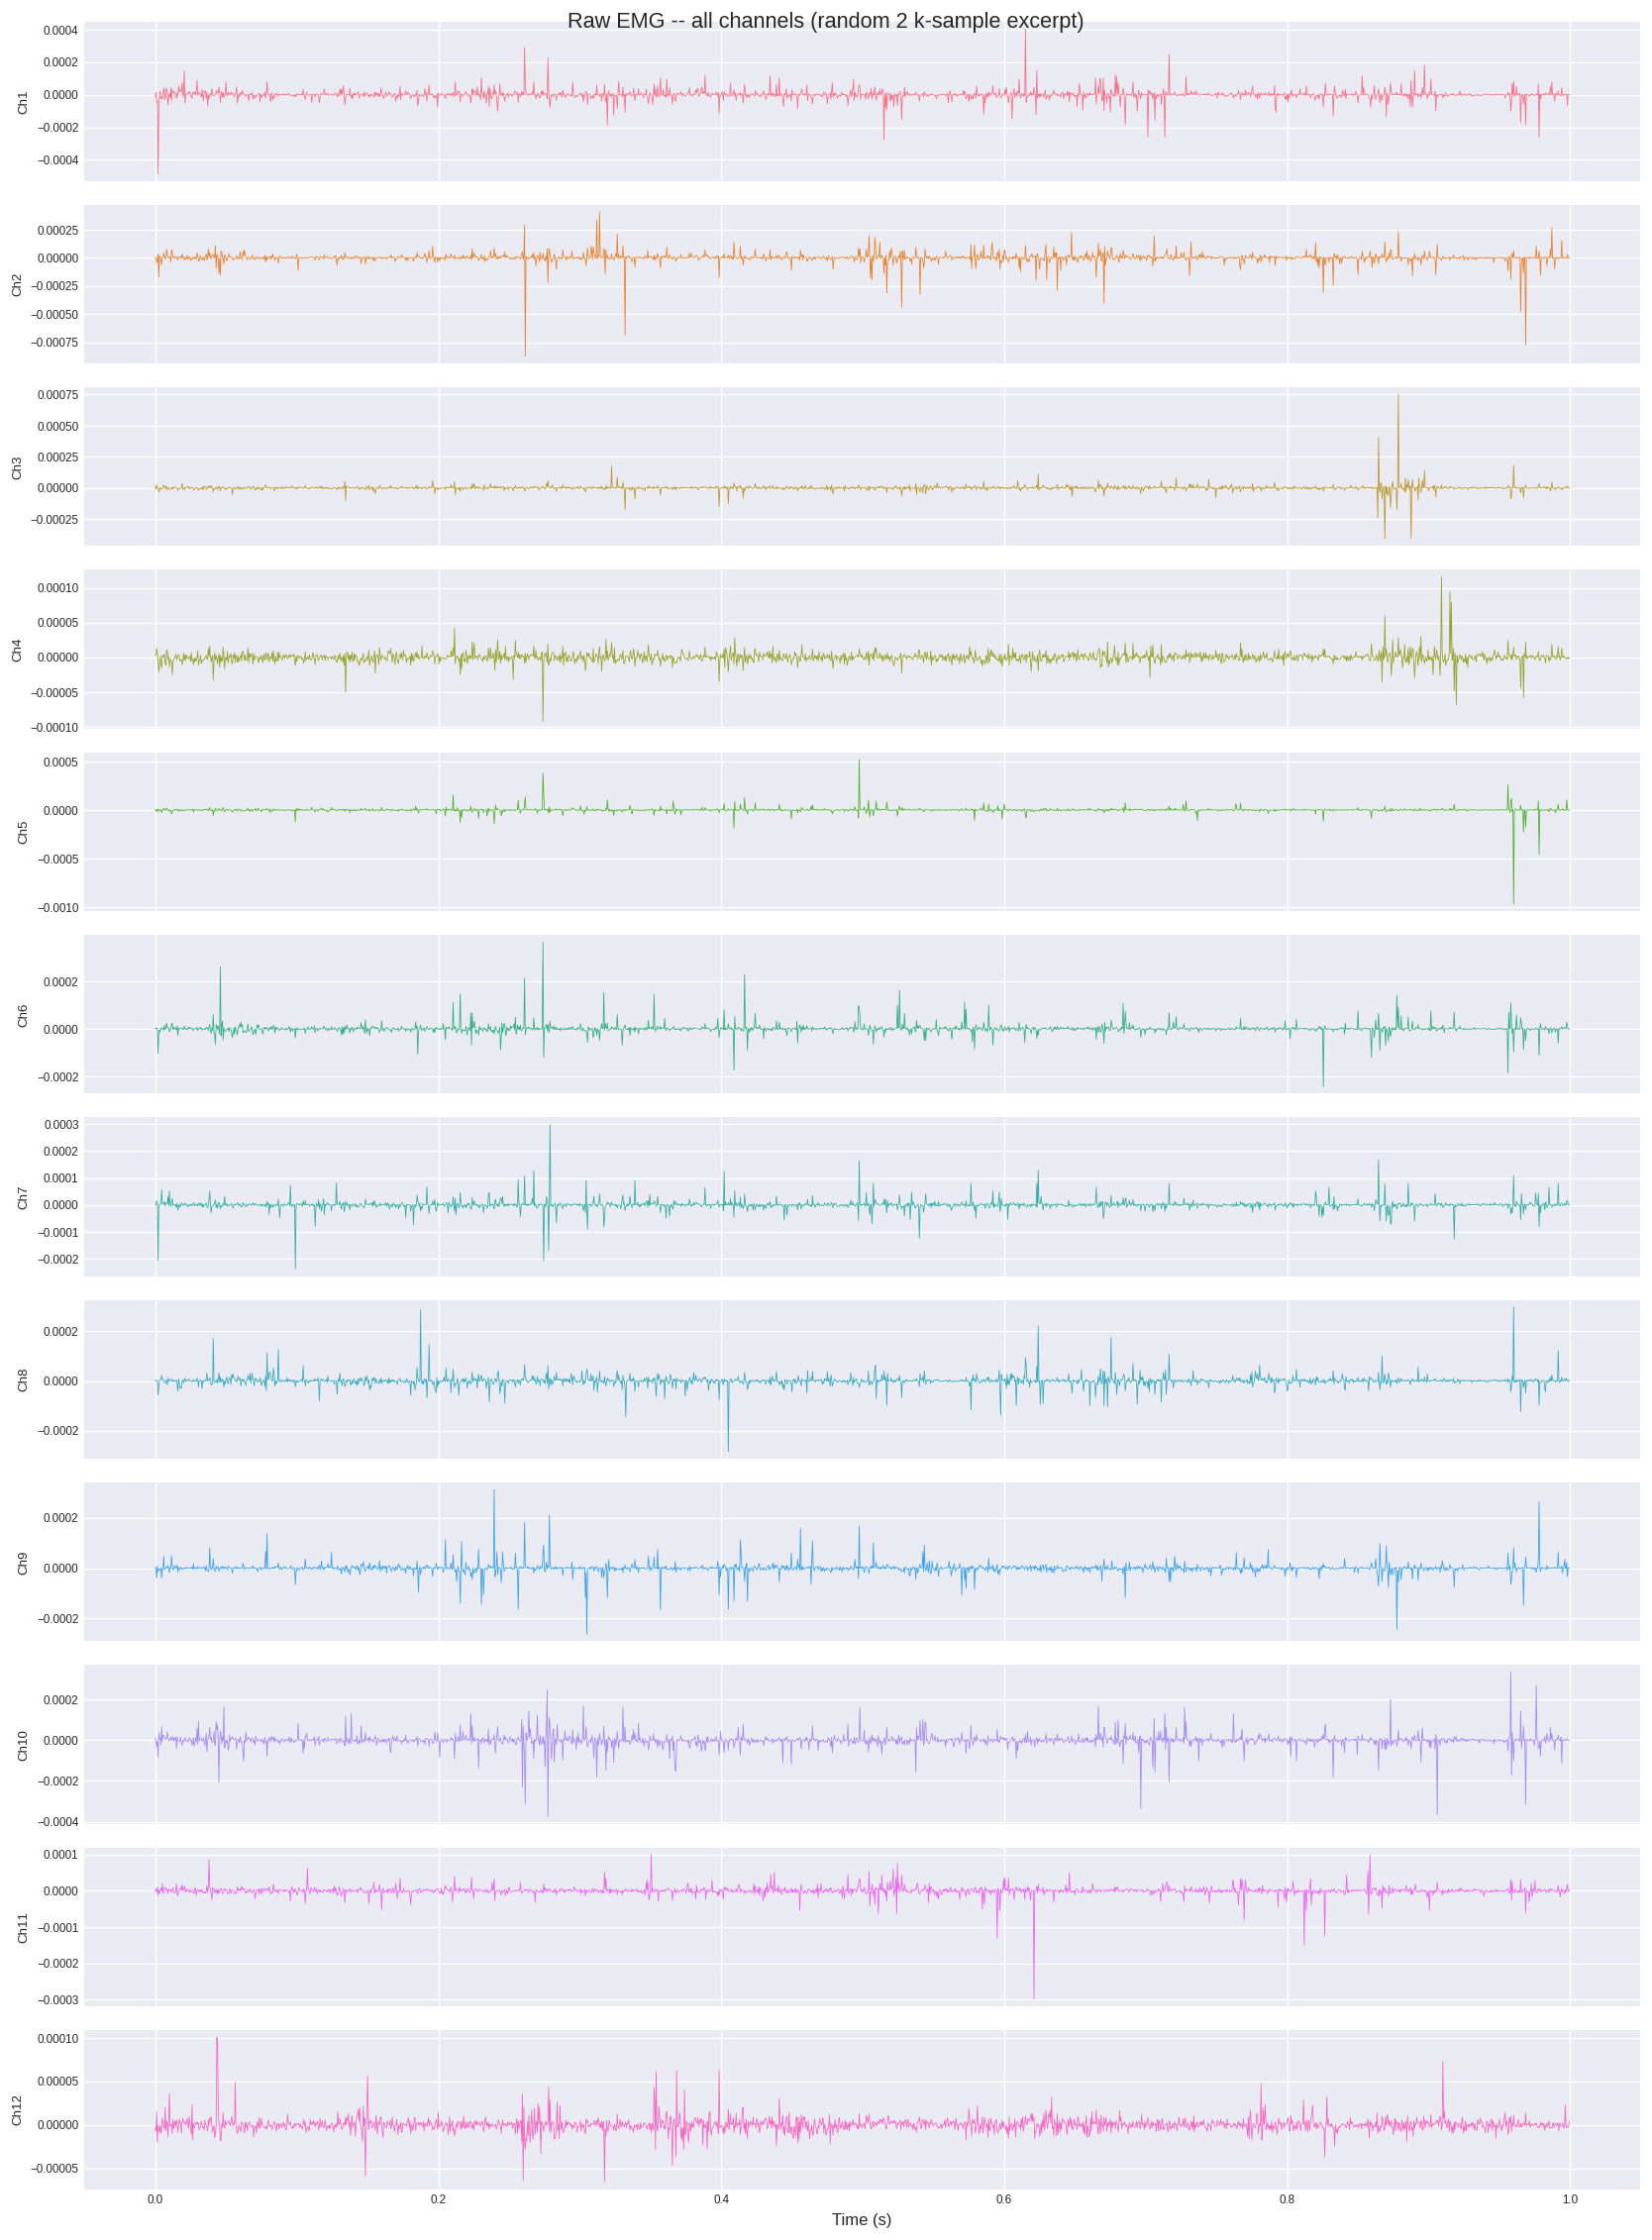

    Saved -> part1_amplitude_distributions.png


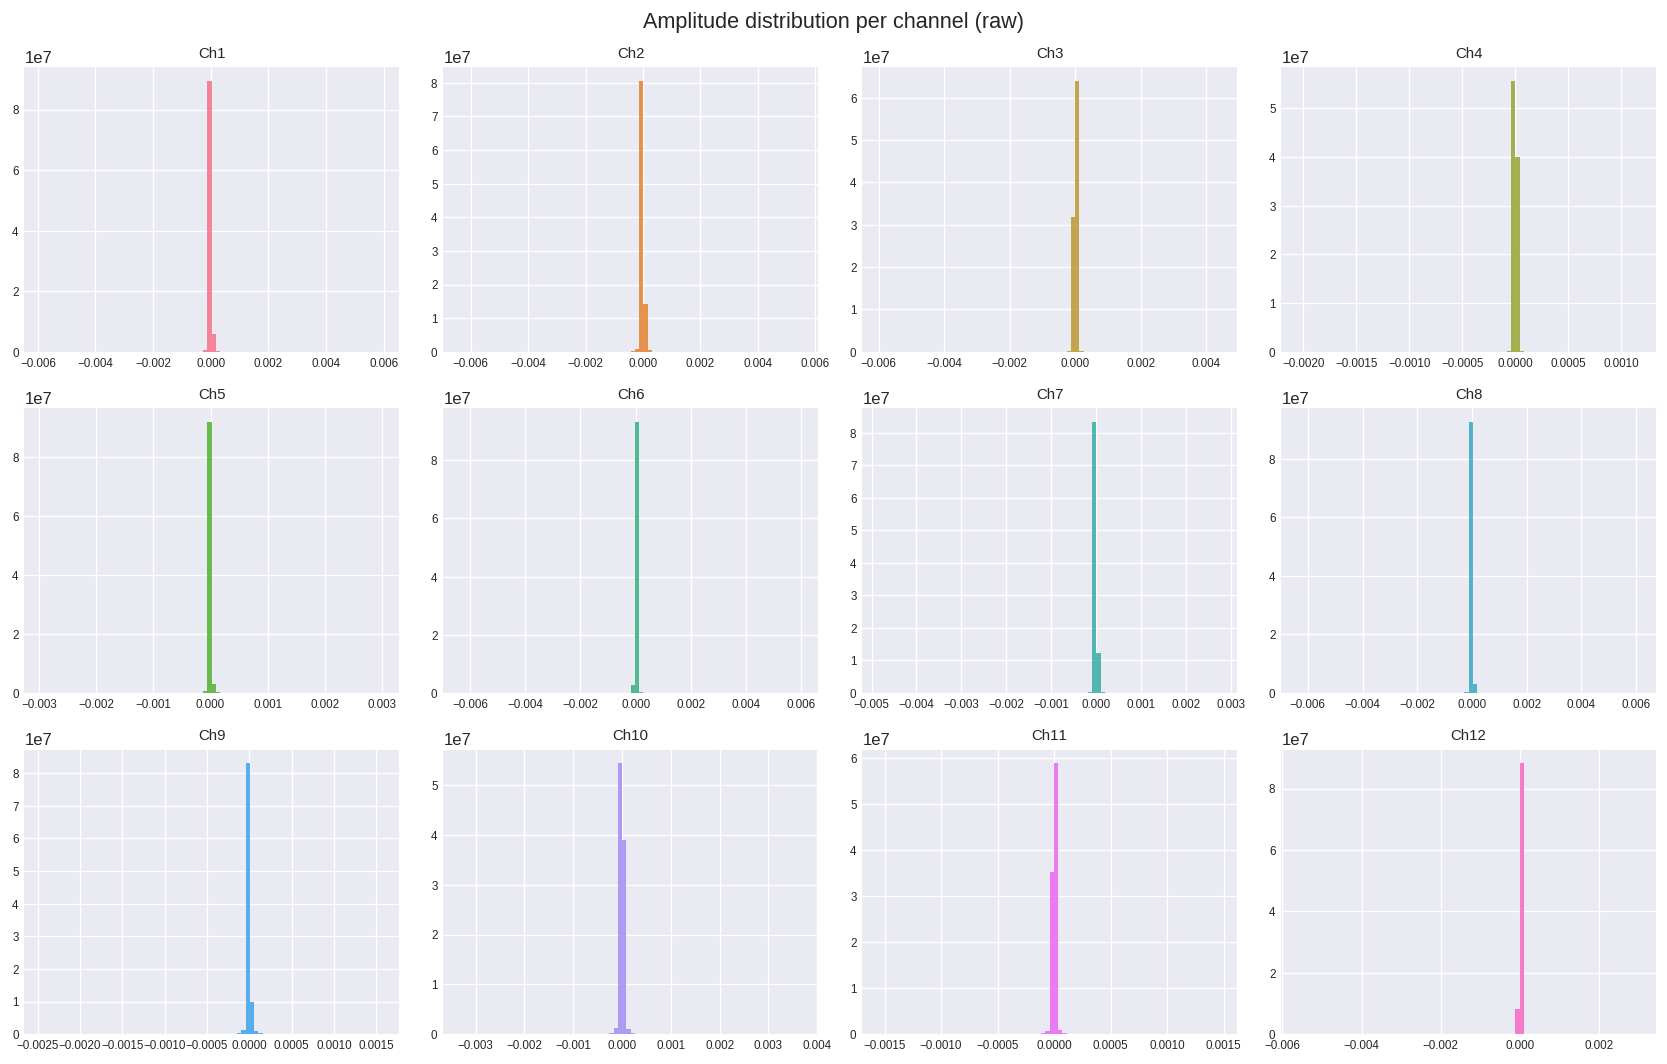


[Part 2] Time-Domain Features
    Saved -> part2_time_domain_features.png


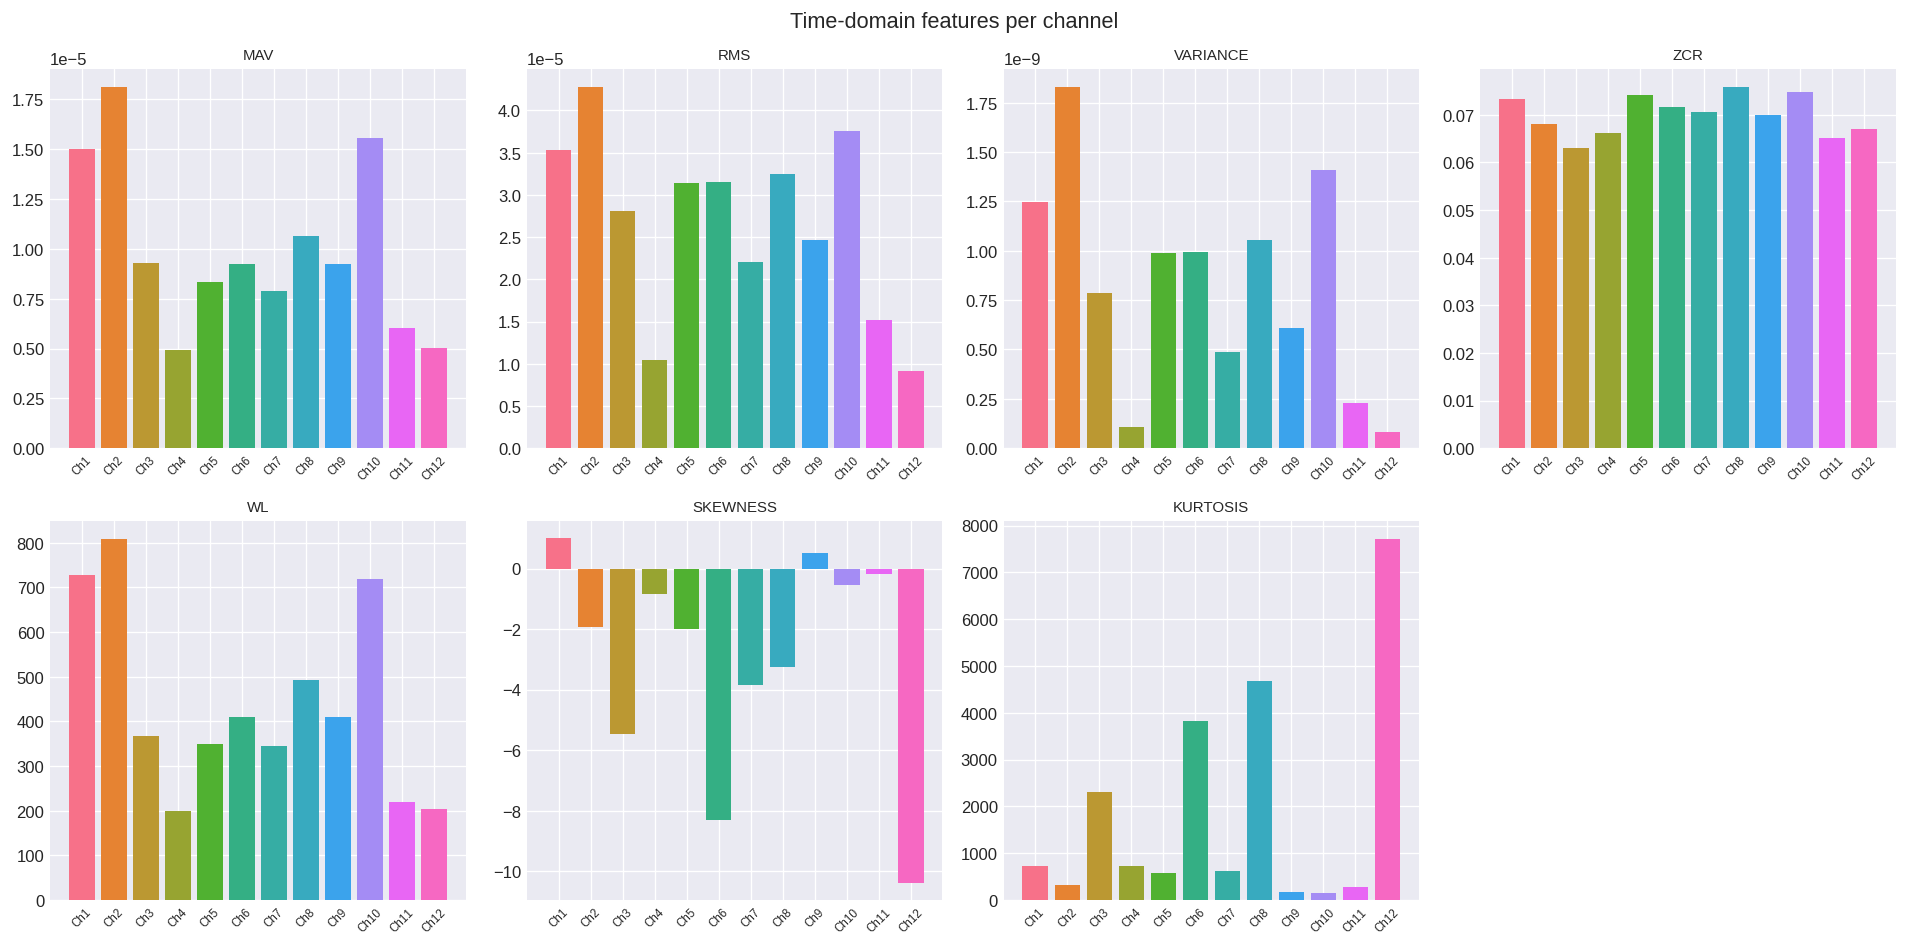


[Part 3] Frequency-Domain Features
    Saved -> part3_psd_per_gesture.png


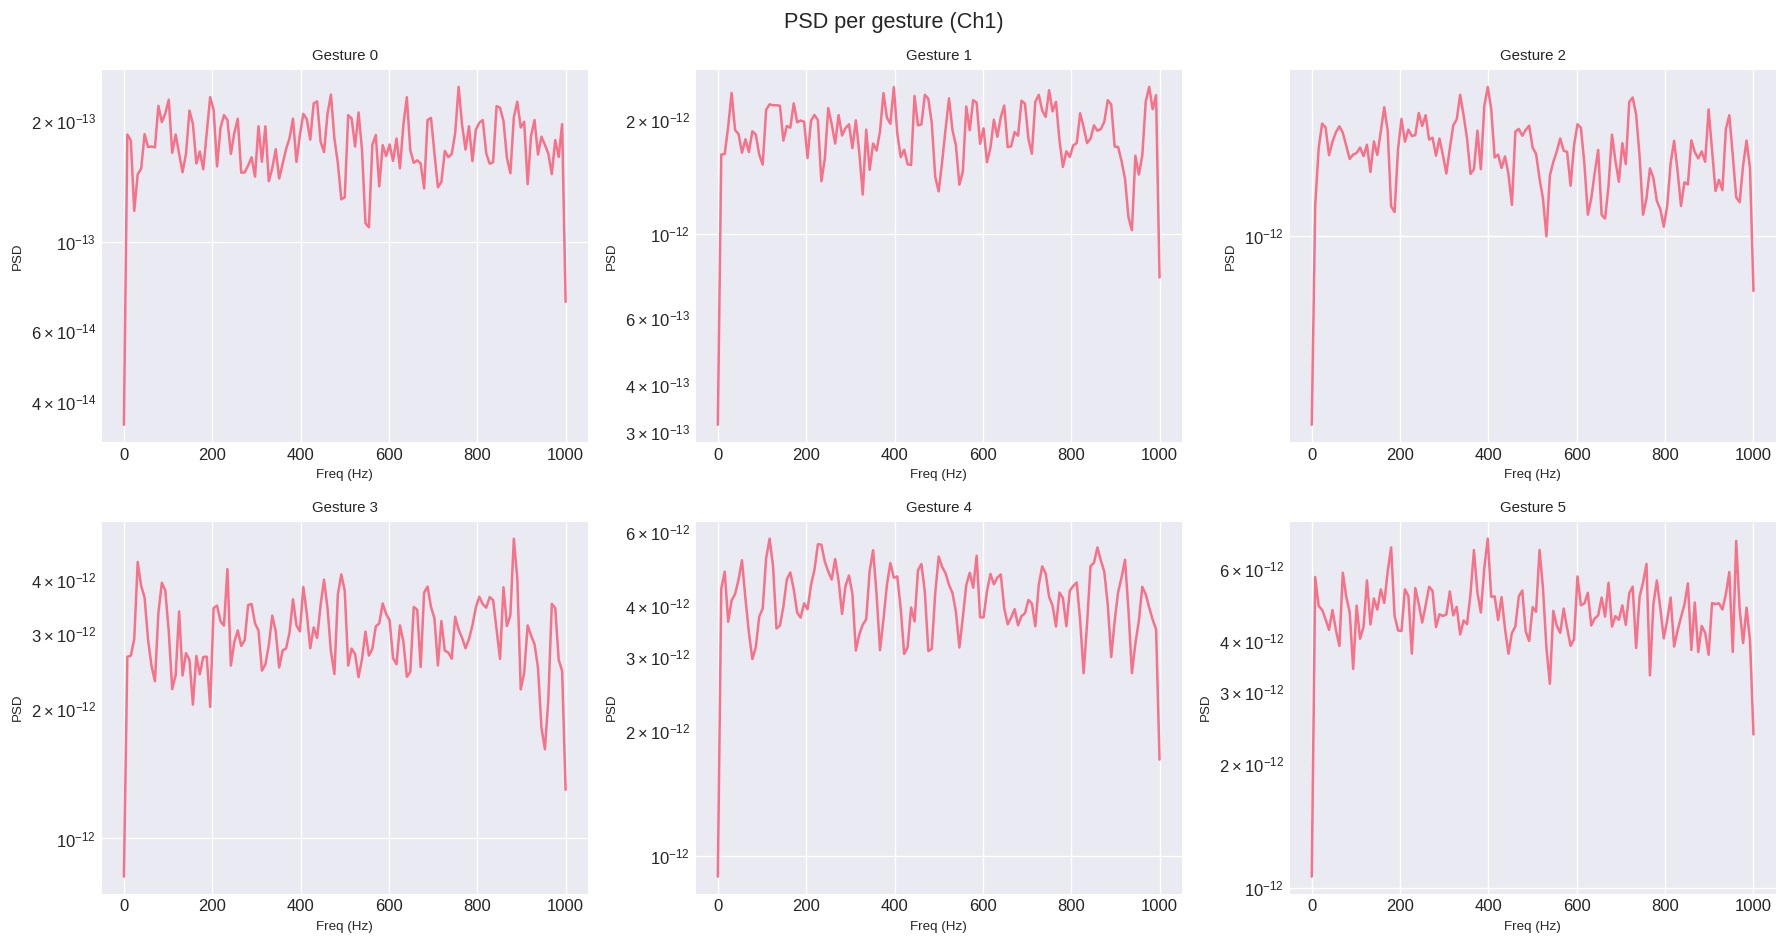

    Saved -> part3_frequency_features.png


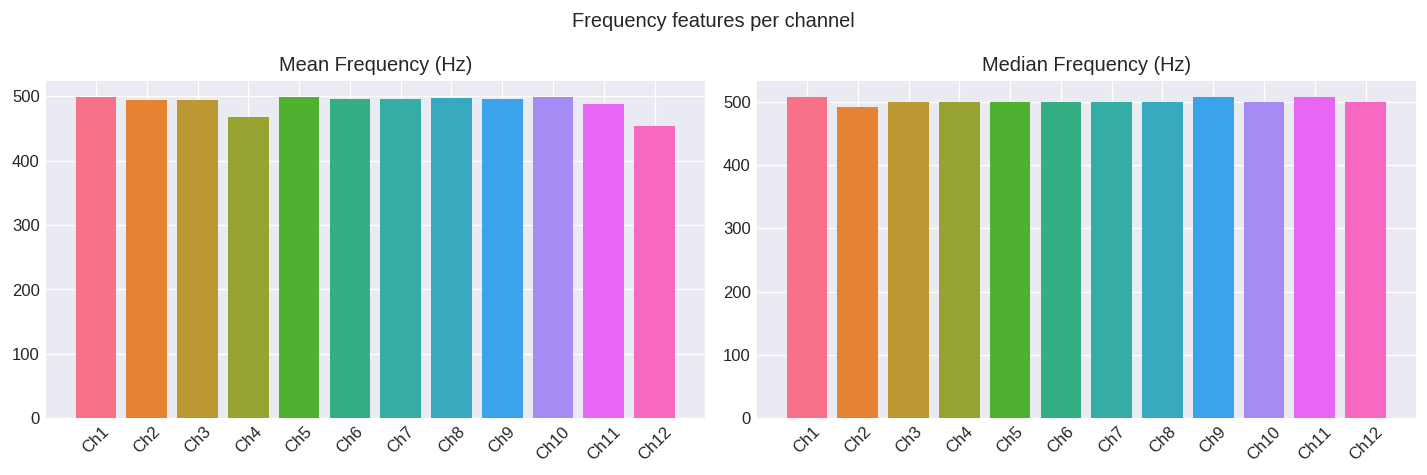


[Part 4] Gesture-Level Analysis
    Saved -> part4_gesture_mav_heatmap.png


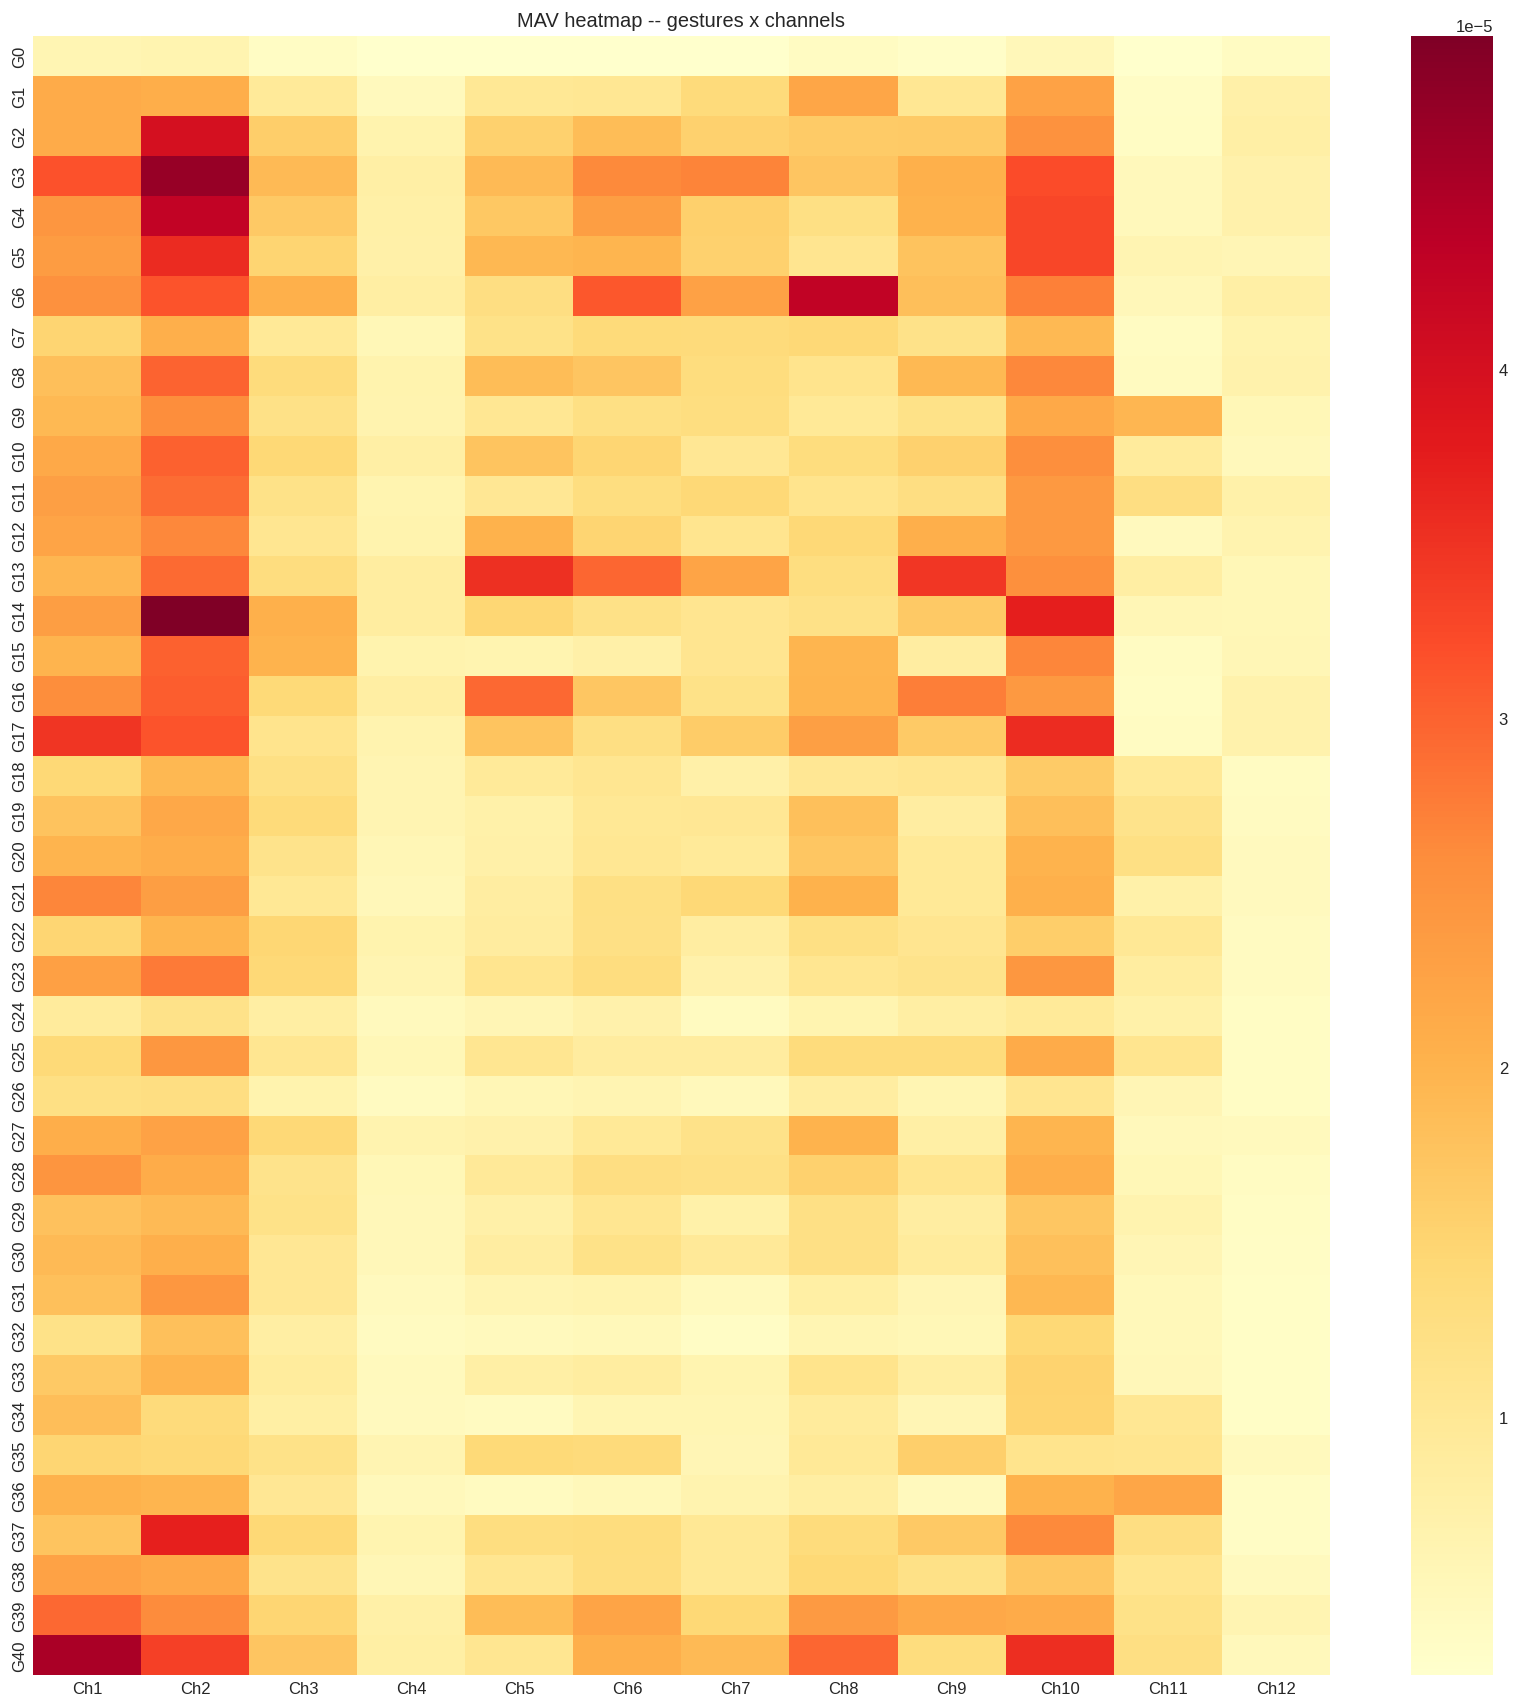

    Saved -> part4_class_balance.png


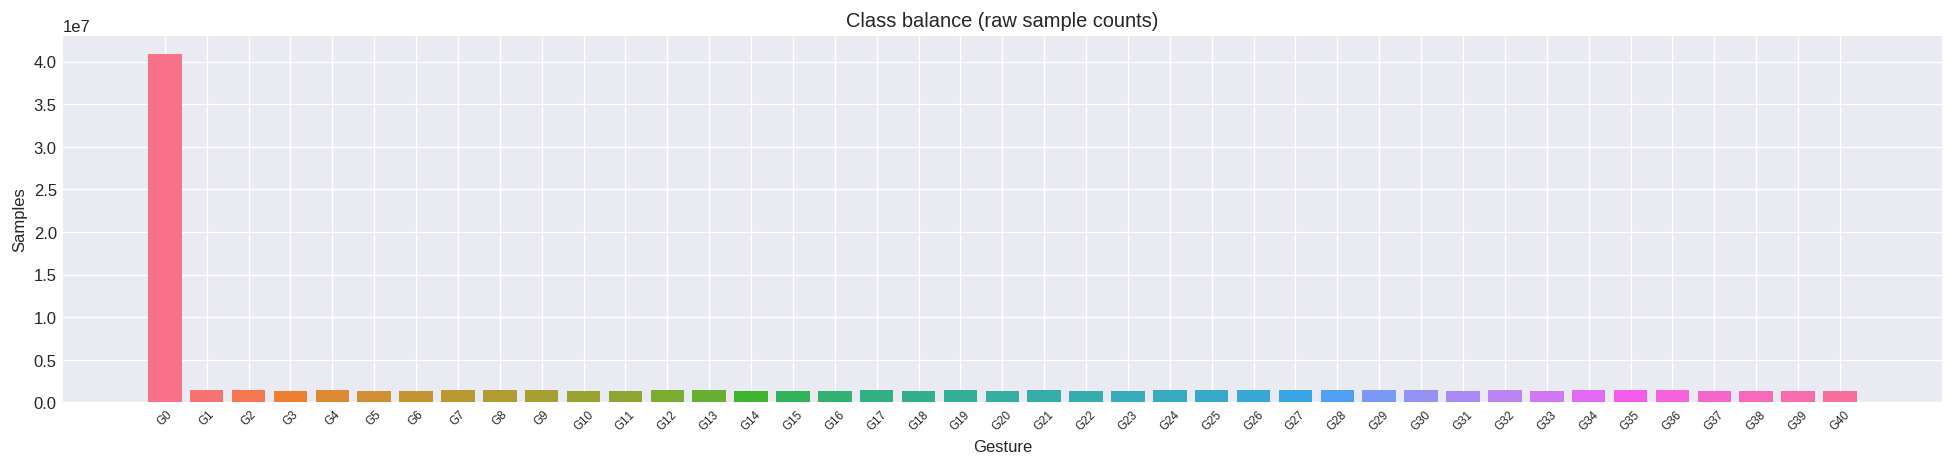


[Part 5] PCA
    Saved -> part5_pca.png


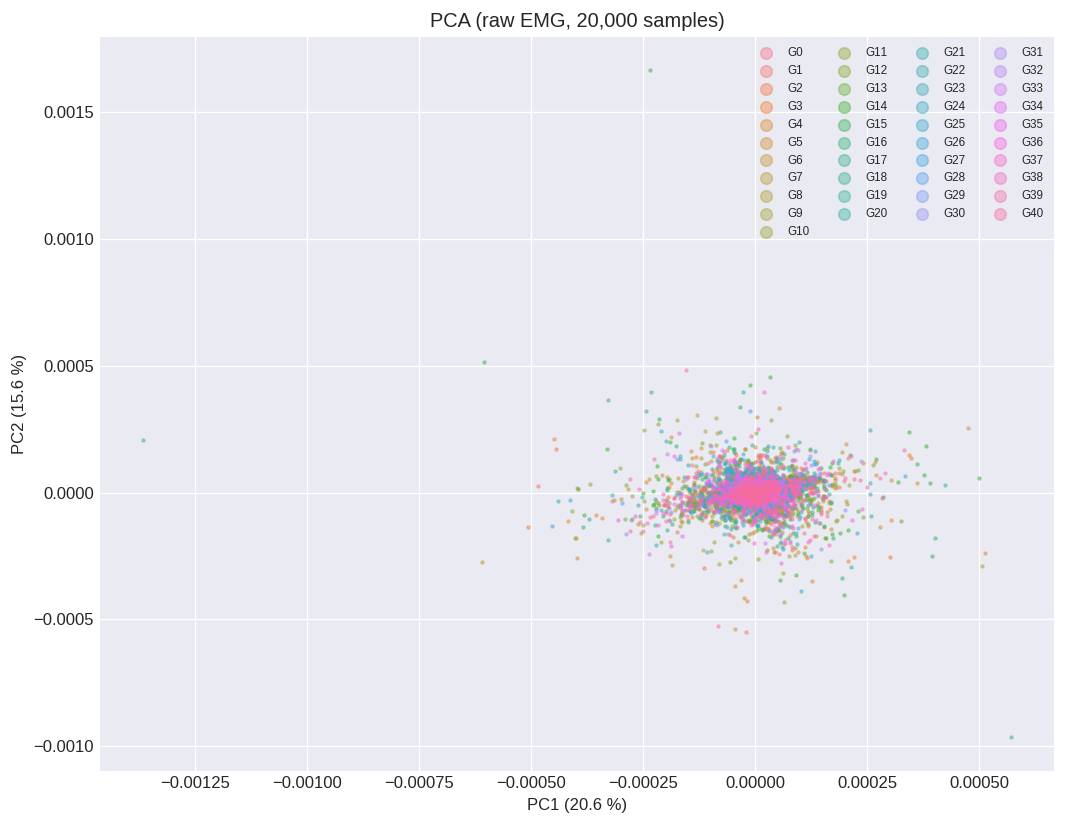


[Part 6] Channel Correlation
    Saved -> part6_channel_correlation.png


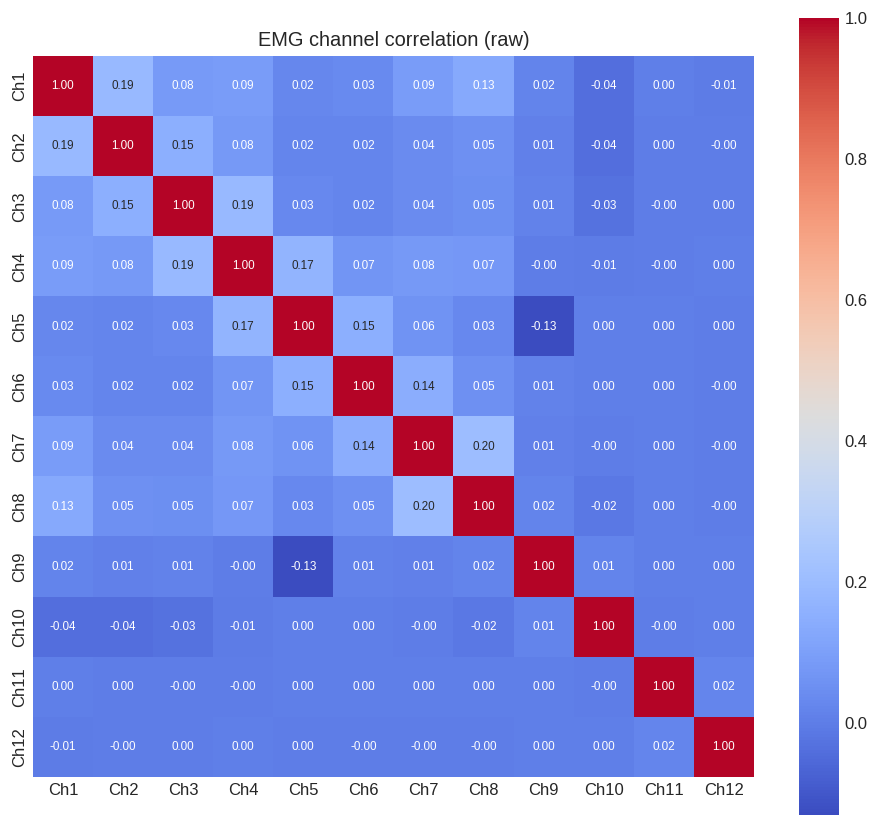

In [8]:
eda = EMGSignalEDA(
    emg_signals = emg_sample,
    labels      = labels_sample,
    save_dir    = Config.PLOT_DIR,
)
eda_results = eda.run_all()

## Summary

In [9]:
td = eda_results['time_domain']
fr = eda_results['freq_domain']

summary_df = pd.DataFrame({
    'Channel'         : [f'Ch{i+1}' for i in range(Config.EMG_CHANNELS)],
    'MAV'             : td['mav'],
    'RMS'             : td['rms'],
    'Variance'        : td['variance'],
    'ZCR'             : td['zcr'],
    'Skewness'        : td['skewness'],
    'Kurtosis'        : td['kurtosis'],
    'Mean Freq (Hz)'  : fr['mean_freq'],
    'Median Freq (Hz)': fr['median_freq'],
    'Total Power'     : fr['total_power'],
}).set_index('Channel').round(4)

display(summary_df)

print(f"\n{'='*55}")
print(f"  Samples analysed : {eda_results['n_samples']:,}")
print(f"  Channels         : {eda_results['n_channels']}")
print(f"  Gesture classes  : {eda_results['n_gestures']}")
print(f"  Checkpoints dir  : {Config.CHECKPOINT_DIR}")
print(f"  Plots dir        : {Config.PLOT_DIR}")
print(f"{'='*55}")

plots = sorted(Config.PLOT_DIR.glob('*.png'))
print(f'\n{len(plots)} plots saved:')
for p in plots:
    print(f'  {p.name}')

,MAV,RMS,Variance,ZCR,Skewness,Kurtosis,Mean Freq (Hz),Median Freq (Hz),Total Power
Channel,,,,,,,,,
Ch1,0.0,0.0,0.0,0.0732,1.0062,715.247986,498.9438,507.8125,0.0
Ch2,0.0,0.0,0.0,0.0680,-1.9267,320.351898,493.8348,492.1875,0.0
Ch3,0.0,0.0,0.0,0.0630,-5.4554,2315.462891,494.5430,500.0000,0.0
Ch4,0.0,0.0,0.0,0.0663,-0.8244,727.896912,467.2460,500.0000,0.0
Ch5,0.0,0.0,0.0,0.0742,-2.0115,579.318298,497.9753,500.0000,0.0
Ch6,0.0,0.0,0.0,0.0717,-8.2944,3819.693115,495.7488,500.0000,0.0
Ch7,0.0,0.0,0.0,0.0706,-3.8341,626.975403,494.7610,500.0000,0.0
Ch8,0.0,0.0,0.0,0.0758,-3.2547,4685.466797,496.8593,500.0000,0.0
Ch9,0.0,0.0,0.0,0.0699,0.5060,162.693405,495.6557,507.8125,0.0



  Samples analysed : 96,355,557
  Channels         : 12
  Gesture classes  : 41
  Checkpoints dir  : /kaggle/working/checkpoints
  Plots dir        : /kaggle/working/eda_plots

9 plots saved:
  part1_amplitude_distributions.png
  part1_raw_signals.png
  part2_time_domain_features.png
  part3_frequency_features.png
  part3_psd_per_gesture.png
  part4_class_balance.png
  part4_gesture_mav_heatmap.png
  part5_pca.png
  part6_channel_correlation.png
